# Step 3: Conducting Analysis

Now, we will perform the final step of this project: conducting our analysis!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First, we have to upload our datasets and convert them to a Dataset object format.

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

! kaggle datasets download adhok93/inauguration-and-womensmarch-tweets
! unzip inauguration-and-womensmarch-tweets.zip

! kaggle datasets download prathamsharma123/farmers-protest-tweets-dataset-csv
! unzip farmers-protest-tweets-dataset-csv.zip

! pip install transformers datasets
! pip install keybert

100% 1.52M/1.52M [00:00<00:00, 2.66MB/s]
100% 1.52M/1.52M [00:00<00:00, 2.48MB/s]
Archive:  inauguration-and-womensmarch-tweets.zip
  inflating: inauguration.csv        
  inflating: womenmarch.csv          
100% 315M/315M [00:18<00:00, 19.2MB/s]
100% 315M/315M [00:18<00:00, 18.1MB/s]
Archive:  farmers-protest-tweets-dataset-csv.zip
  inflating: tweets.csv              
  inflating: users.csv               
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
from datasets import Dataset
import re

womenmarch = pd.read_csv("womenmarch.csv",encoding='ISO-8859-1')
womenmarch = womenmarch.to_dict()
for col in womenmarch:
  if col == 'text':
    womenmarch[col] = [re.sub(r'[^a-zA-Z0-9\s]+', '', re.sub(r'http\S+', '', tweet)) for tweet in womenmarch[col].values()]
  else:
    womenmarch[col] = list(womenmarch[col].values())
womenmarch = Dataset.from_pandas(pd.DataFrame(data=womenmarch))

farmers = pd.read_csv("tweets.csv",encoding='ISO-8859-1')
farmers['date'] = pd.to_datetime(farmers['date'])
farmers.sort_values(by='date', inplace = True)
farmers = farmers.to_dict()
for col in farmers:
  if col == 'renderedContent':
    farmers[col] = [re.sub(r'[^a-zA-Z0-9\s]+', '', re.sub(r'http\S+', '', tweet)) for tweet in farmers[col].values()]
  else:
    farmers[col] = list(farmers[col].values())
farmers = Dataset.from_pandas(pd.DataFrame(data=farmers))

We're also going to load our models.

In [ ]:
from transformers import AutoModelForSequenceClassification
from keybert import KeyBERT

sentiment_model = AutoModelForSequenceClassification.from_pretrained('mayapapaya/Sentiment-Analyzer')
keyword_model = KeyBERT()

Now, we can start conducting our analysis!


---

# Analysis

In this analysis, I am creating three different functions, each with their own task: public sentiment, public sentiment within a certain time period, and keyword extracting.


### Function 1: Public Sentiment
This function is to determine the majority sentiment towards the movement.

*Parameters: dataset, tweet_index*

*Return Value: variables that list the sentiments of a dataset of tweets*

In [ ]:
from transformers import pipeline

def public_sentiment(dataset, tweet_index):
  positive, negative, neutral = [], [], []

  # Input the tweet text into the model
  generator = pipeline('sentiment-analysis',
                    model=sentiment_model,
                    tokenizer='bert-base-uncased')

  # Determine the tweet text's sentiment
  for row in dataset:
    sentiment = generator(row[tweet_index], max_length=512, truncation=True)
    if sentiment[0]['label'] == "LABEL_1":
      neutral.append(row[tweet_index])
    elif sentiment[0]['label'] == "LABEL_0":
      negative.append(row[tweet_index])
    elif sentiment[0]['label'] == "LABEL_2":
      positive.append(row[tweet_index])

  # Returns a list of each sentiment and the total number of tweets
  return len(dataset), positive, neutral, negative

### Function 2: Segmenting Dataset by Date

This function segments a dataset within the specified time period.

*Parameters: start_date, end_date (both are datetime objects), dataset, time_index*

*Return Value: a dataset*

In [ ]:
from datetime import datetime
from datasets import Dataset

def segment_by_date(start_date, end_date, dataset, time_index):

  start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S%z')
  end_date = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S%z')

  # Segment dataset into the specified time period
  start_date_index = 0
  end_date_index = len(dataset) - 1

  for i in range(end_date_index + 1):
    if start_date_index != 0 or dataset[i][time_index] >= start_date:
      start_date_index = i
      break

  for i in range(start_date_index, len(dataset)):
      if end_date <= dataset[i][time_index]:
        end_date_index = i
        break

  seg_dataset = Dataset.from_dict(dataset[start_date_index:end_date_index])

  return seg_dataset

### Function 3: Keyword Extractor

This function is to determine the most popular keywords or topics of discussion.

*Parameters: dataset*

*Return Value: dictionary where keys are keywords and values are the percentages they appeared*

In [ ]:
def keyword_extractor(dataset):
  keyword_to_percent = {}

  for tweet in dataset:
    # Input the tweet text into the model
    tweet_keywords = keyword_model.extract_keywords(tweet, keyphrase_ngram_range=(1, 2))

    for keyword in tweet_keywords:
      if keyword[0] not in keyword_to_percent:
        keyword_to_percent[keyword[0]] = 1
      else:
        keyword_to_percent[keyword[0]] += 1


  return sorted(keyword_to_percent.items(), key=lambda x:x[1], reverse=True)

### Extra Functions

In [ ]:
def print_top(my_list, num):
  counter = 1
  for keyword in my_list:
    print(str(counter) + ". " + str(keyword))
    if counter == num:
      break
    counter += 1

I'm also going to create a function that prints out a wordcloud. (I borrowed the code from this analysis: https://towardsdatascience.com/analysis-of-tweets-on-the-hong-kong-protest-movement-2019-with-python-a331851f061)

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
  wordcloud = WordCloud(
      background_color = 'white',
      max_words = 200,
      max_font_size = 40,
      scale = 3,
      random_state = 42
      ).generate(str(data))
  fig = plt.figure(1, figsize = (15, 15))
  plt.axis('off')
  if title:
      fig.suptitle(title, fontsize = 20)
      fig.subplots_adjust(top = 2.3)
  plt.imshow(wordcloud)
  plt.show()

This function is meant to simplify and condense the analysis for each dataset into a single function call.

In [ ]:
def analyze(dataset, start_date, end_date, tweet_index):
  print("Public Sentiment between " + start_date + " and " + end_date + ": ")
  print()

  # Prints the sentiments
  length, positives, neutrals, negatives = public_sentiment(dataset, tweet_index)
  print("Positive Tweets: " + str(len(positives)))
  print("Neutral Tweets: " + str(len(neutrals)))
  print("Negative Tweets: " + str(len(negatives)))
  print()
  print("Total Tweets: " + str(length))
  print()

  # Prints the top ten keywords
  print("Keywords:")
  print()
  keyword_to_percent = keyword_extractor(dataset[tweet_index])
  print_top(keyword_to_percent, 10)
  print("Positive Keywords: ")
  keyword_to_percent = keyword_extractor(positives)
  print_top(keyword_to_percent, 10)
  print("Neutral Keywords: ")
  keyword_to_percent = keyword_extractor(neutrals)
  print_top(keyword_to_percent, 10)
  print("Negative Keywords: ")
  keyword_to_percent = keyword_extractor(negatives)
  print_top(keyword_to_percent, 10)
  print()

  # Prints the wordclouds for each sentiment
  print("Wordcloud (Positive):")
  show_wordcloud(positives)
  print("Wordcloud (Negative):")
  show_wordcloud(negatives)
  print("Wordcloud (Neutral):")
  show_wordcloud(neutrals)

  return length, positives, neutrals, negatives, keyword_to_percent


Now let's analyze our datasets using these functions!

## WomensMarch Analysis

We'll start with the #WomensMarch dataset:

Public Sentiment between 2017-02-08 05:14:24 and 2017-02-07 04:09:25: 

Positive Tweets: 3034
Neutral Tweets: 9209
Negative Tweets: 2757

Total Tweets: 15000

Keywords:

1. ('womensmarch', 6393)
2. ('rt womensmarch', 2644)
3. ('future female', 1781)
4. ('female references', 1671)
5. ('references womensmarch', 1670)
6. ('womensmarch htt', 1654)
7. ('education devos', 1489)
8. ('communities womensmarch', 1488)
9. ('womensmarch power', 1486)
10. ('demi lovato', 944)
Positive Keywords: 
1. ('womensmarch', 1534)
2. ('rt womensmarch', 1020)
3. ('unstoppable womensmarch', 641)
4. ('womensmarch rt', 640)
5. ('cecilerichards movement', 640)
6. ('shoutout womensmarch', 384)
7. ('hillaryclinton shoutout', 381)
8. ('womensmarch thank', 380)
9. ('womens march', 167)
10. ('womensmarch womensmarch', 140)
Neutral Keywords: 
1. ('womensmarch', 4313)
2. ('future female', 1751)
3. ('female references', 1671)
4. ('references womensmarch', 1670)
5. ('womensmarch htt', 1654)
6. ('rt womensmarch', 1581)
7. (

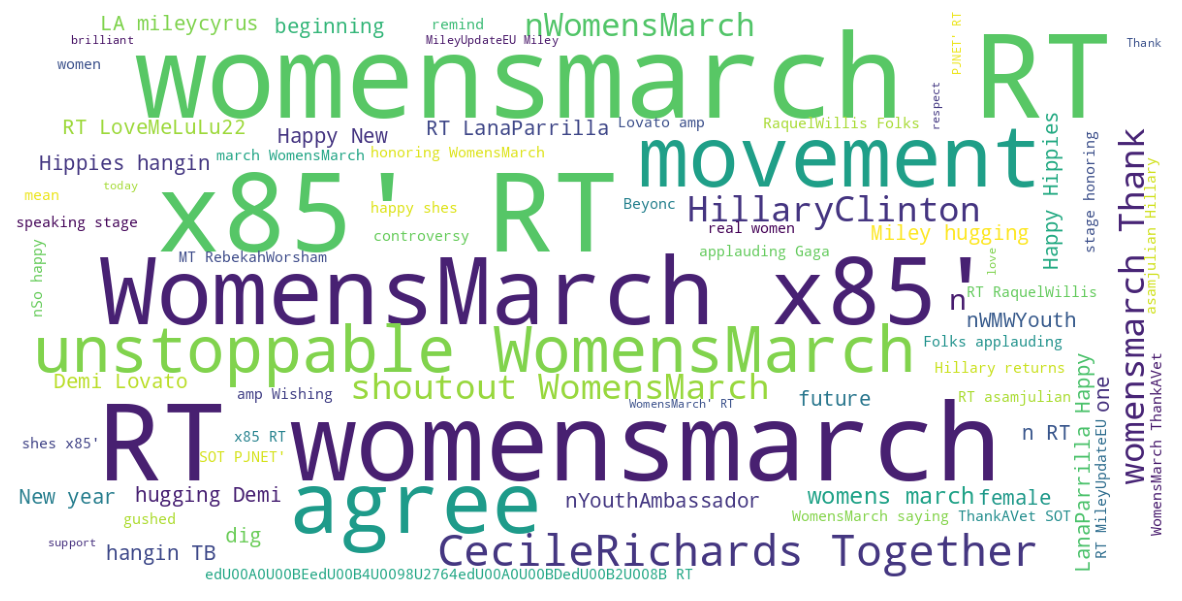

Wordcloud (Negative):


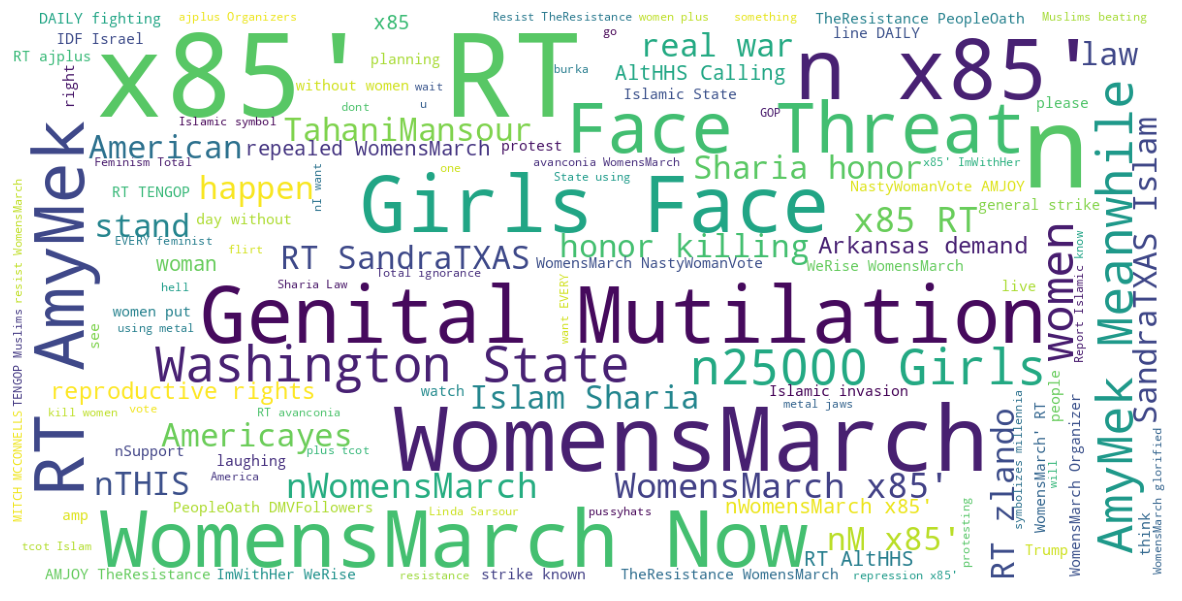

Wordcloud (Neutral):


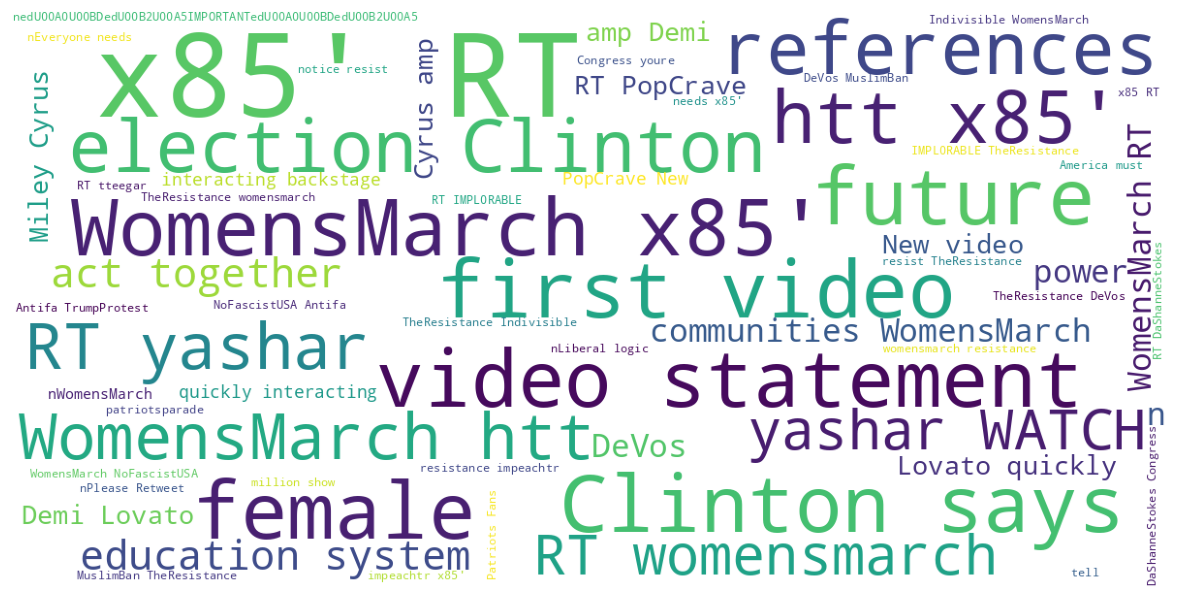

In [ ]:
length, positives, neutrals, negatives, keyword_to_percent = analyze(womenmarch, womenmarch['created'][0], womenmarch['created'][-1], 'text')



```
Public Sentiment between 2017-02-08 05:14:24 and 2017-02-07 04:09:25:

Positive Tweets: 3,034
Neutral Tweets: 9,209
Negative Tweets: 2,757

Total Tweets: 15,000

Keywords:
1. ('womensmarch', 6393)
2. ('rt womensmarch', 2644)
3. ('future female', 1781)
4. ('female references', 1671)
5. ('references womensmarch', 1670)
6. ('womensmarch htt', 1654)
7. ('education devos', 1489)
8. ('communities womensmarch', 1488)
9. ('womensmarch power', 1486)
10. ('demi lovato', 944)

Positive Keywords:
1. ('womensmarch', 1534)
2. ('rt womensmarch', 1020)
3. ('unstoppable womensmarch', 641)
4. ('womensmarch rt', 640)
5. ('cecilerichards movement', 640)
6. ('shoutout womensmarch', 384)
7. ('hillaryclinton shoutout', 381)
8. ('womensmarch thank', 380)
9. ('womens march', 167)
10. ('womensmarch womensmarch', 140)

Neutral Keywords:
1. ('womensmarch', 4313)
2. ('future female', 1751)
3. ('female references', 1671)
4. ('references womensmarch', 1670)
5. ('womensmarch htt', 1654)
6. ('rt womensmarch', 1581)
7. ('womensmarch power', 1486)
8. ('communities womensmarch', 1485)
9. ('education devos', 1485)
10. ('demi', 839)

Negative Keywords:
1. ('womensmarch', 546)
2. ('genital mutilation', 450)
3. ('threat genital', 442)
4. ('amymek washington', 441)
5. ('rt amymek', 441)
6. ('amymek', 441)
7. ('sharia', 164)
8. ('islam sharia', 125)
9. ('war women', 124)
10. ('sandratxas islam', 122)
```



## The Indian Farmers' Protest Analysis

Now, we'll look at our second dataset:

In [ ]:
length, positives, neutrals, negatives, keyword_to_percent = analyze(farmers, "start_date", "end_date", 'renderedContent')



```
Public Sentiment between start_date and end_date:

Positive Tweets: 193,742
Neutral Tweets: 504,129
Negative Tweets: 386,581

Total Tweets: 1,084,452

Keywords:
1. ('farmersprotest', 469192)
2. ('farmers', 84296)
3. ('farmers farmersprotest', 32333)
4. ('support farmers', 29321)
5. ('farmers protest', 20979)
6. ('protest', 20465)
7. ('bjp', 19193)
8. ('support farmersprotest', 17318)
9. ('farm laws', 15796)
10. ('indian farmers', 12893)
```



Public Sentiment between 2020-11-29 00:00:00+00:00 and 2021-03-22 00:00:00+00:00: 



Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


Positive Tweets: 116545
Neutral Tweets: 283172
Negative Tweets: 216239

Total Tweets: 615956

Keywords:

1. ('farmersprotest', 254161)
2. ('farmers', 40145)
3. ('farmers farmersprotest', 16621)
4. ('support farmers', 14814)
5. ('rihanna', 12096)
6. ('protest', 11997)
7. ('farmers protest', 11825)
8. ('support farmersprotest', 10334)
9. ('bjp', 8947)
10. ('indian farmers', 8479)
Positive Keywords: 
1. ('farmersprotest', 66553)
2. ('farmers', 7400)
3. ('support farmers', 6318)
4. ('support farmersprotest', 5879)
5. ('rihanna', 5664)
6. ('farmers farmersprotest', 5638)
7. ('supporting farmersprotest', 2548)
8. ('farmersprotest istandwithfarmers', 2484)
9. ('gretathunberg', 2437)
10. ('supporting farmers', 2176)
Neutral Keywords: 
1. ('farmersprotest', 130616)
2. ('farmers', 18327)
3. ('farmers farmersprotest', 8116)
4. ('farmers protest', 6617)
5. ('support farmers', 6421)
6. ('protest', 5222)
7. ('rihanna', 4375)
8. ('indian farmers', 4221)
9. ('stand farmers', 3801)
10. ('farm laws', 34

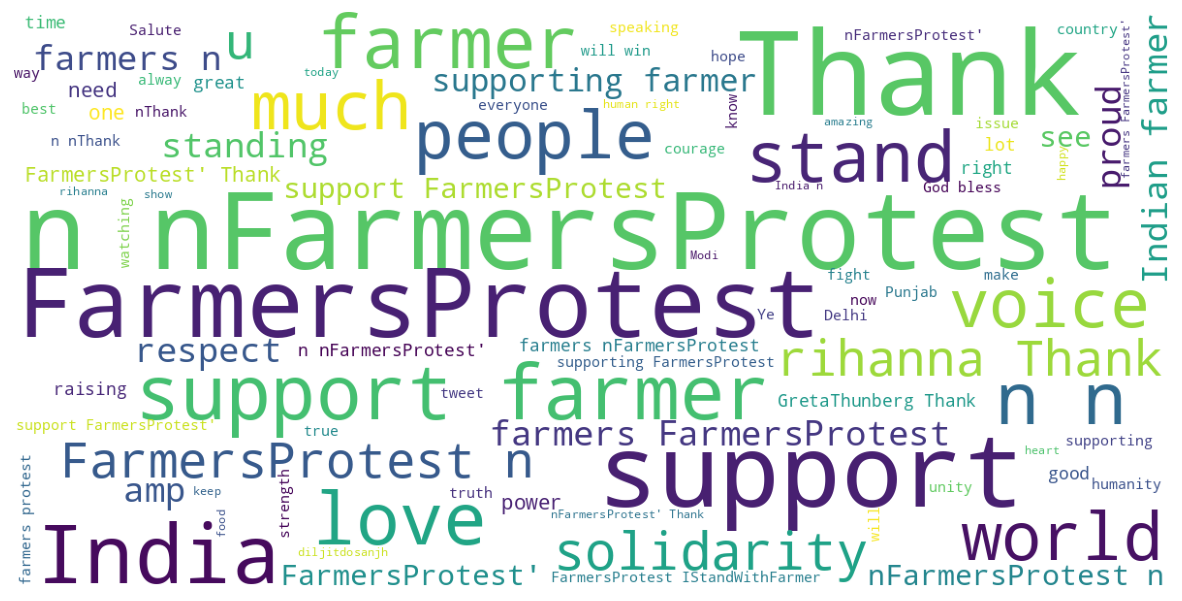

Wordcloud (Negative):


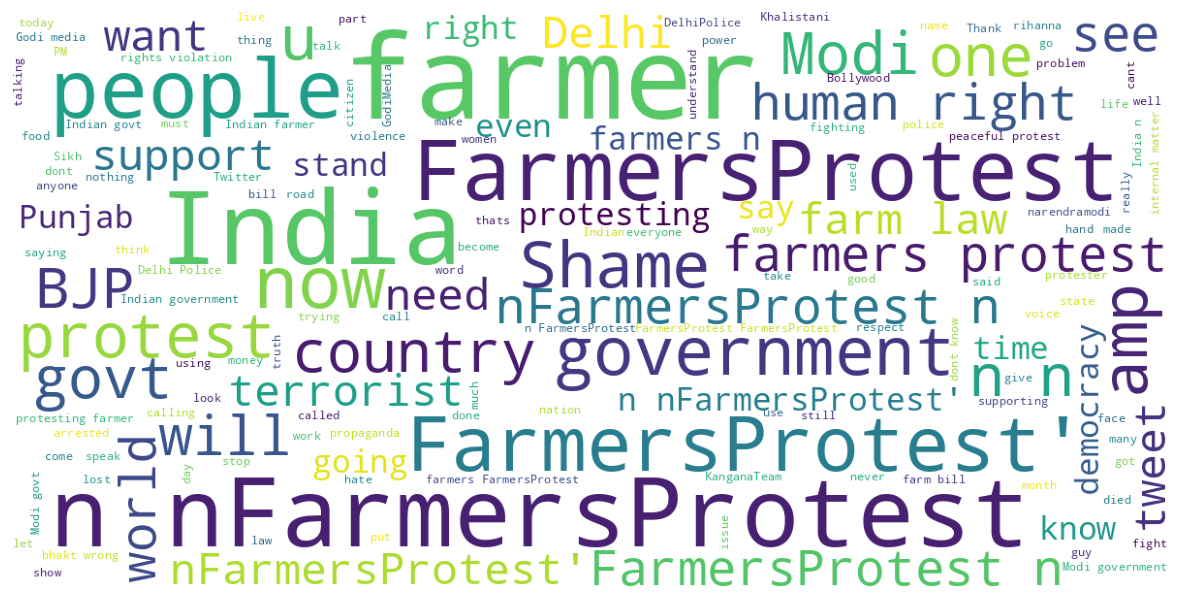

Wordcloud (Neutral):


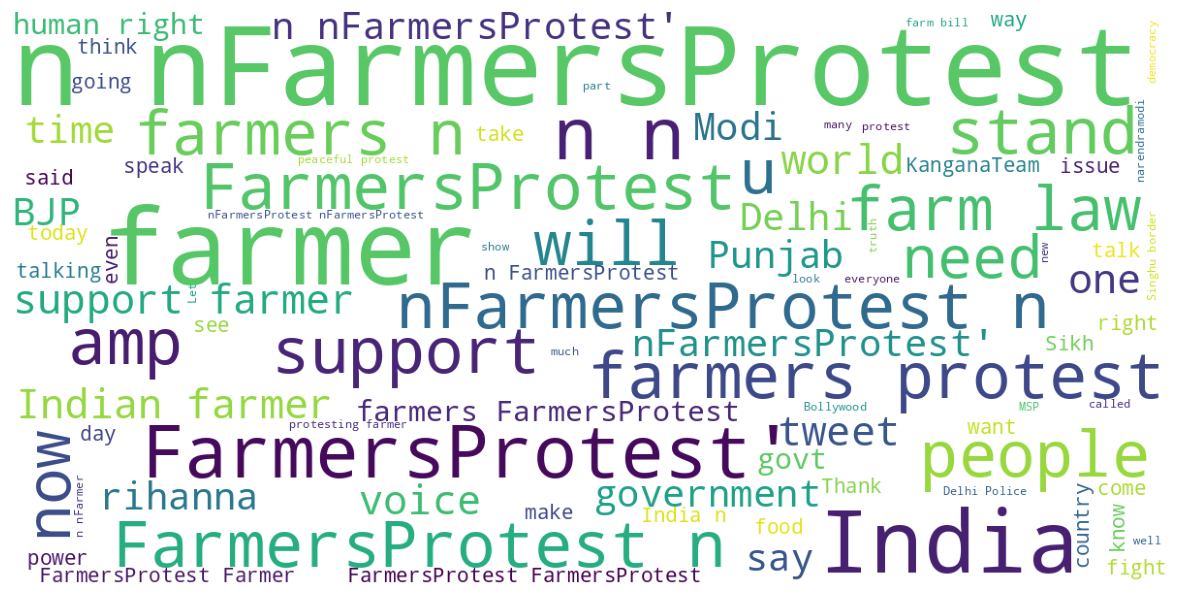

In [11]:
start_date = "2020-11-29 00:00:00+00:00"
end_date = "2021-03-22 00:00:00+00:00"
seg_dataset1 = segment_by_date(start_date, end_date, farmers, 'date')
length, positives, neutrals, negatives, keyword_to_percent = analyze(seg_dataset1, start_date, end_date, 'renderedContent')



```
Public Sentiment between 2020-11-29 00:00:00+00:00 and 2021-03-22 00:00:00+00:00:

Positive Tweets: 116,545
Neutral Tweets: 283,172
Negative Tweets: 216,239

Total Tweets: 615,956

Keywords:
1. ('farmersprotest', 254161)
2. ('farmers', 40145)
3. ('farmers farmersprotest', 16621)
4. ('support farmers', 14814)
5. ('rihanna', 12096)
6. ('protest', 11997)
7. ('farmers protest', 11825)
8. ('support farmersprotest', 10334)
9. ('bjp', 8947)
10. ('indian farmers', 8479)

Positive Keywords:
1. ('farmersprotest', 66553)
2. ('farmers', 7400)
3. ('support farmers', 6318)
4. ('support farmersprotest', 5879)
5. ('rihanna', 5664)
6. ('farmers farmersprotest', 5638)
7. ('supporting farmersprotest', 2548)
8. ('farmersprotest istandwithfarmers', 2484)
9. ('gretathunberg', 2437)
10. ('supporting farmers', 2176)

Neutral Keywords:
1. ('farmersprotest', 130616)
2. ('farmers', 18327)
3. ('farmers farmersprotest', 8116)
4. ('farmers protest', 6617)
5. ('support farmers', 6421)
6. ('protest', 5222)
7. ('rihanna', 4375)
8. ('indian farmers', 4221)
9. ('stand farmers', 3801)
10. ('farm laws', 3456)

Negative Keywords:
1. ('farmersprotest', 56992)
2. ('farmers', 14418)
3. ('protest', 5995)
4. ('bjp', 5619)
5. ('farmers protest', 4321)
6. ('protesting', 3149)
7. ('farmers protesting', 3024)
8. ('farmers farmersprotest', 2867)
9. ('indianfarmershumanrights', 2795)
10. ('farmers india', 2338)
```



Public Sentiment between 2021-11-05 00:00:00+00:00 and 2021-11-21 00:00:00+00:00: 

Positive Tweets: 5098
Neutral Tweets: 11037
Negative Tweets: 8433

Total Tweets: 24568

Keywords:

1. ('farmersprotest', 9343)
2. ('farmers', 1907)
3. ('farmlaws', 1760)
4. ('farmlawsrepealed', 1751)
5. ('farm laws', 1518)
6. ('farmlaws farmersprotest', 1123)
7. ('farmlawsrepealed farmersprotest', 1051)
8. ('farmersprotest farmlaws', 899)
9. ('farmersprotest farmlawsrepealed', 882)
10. ('bjp', 605)
Positive Keywords: 
1. ('farmersprotest', 2623)
2. ('farmers', 456)
3. ('farmlawsrepealed', 317)
4. ('farmlaws', 291)
5. ('farmers farmersprotest', 213)
6. ('farmlawsrepealed farmersprotest', 195)
7. ('farmlaws farmersprotest', 191)
8. ('farmersprotest farmlawsrepealed', 186)
9. ('farmersprotest farmlaws', 172)
10. ('victory farmers', 140)
Neutral Keywords: 
1. ('farmersprotest', 4551)
2. ('farmlaws', 976)
3. ('farmlawsrepealed', 927)
4. ('farm laws', 907)
5. ('farmers', 661)
6. ('farmlaws farmersprotest', 65

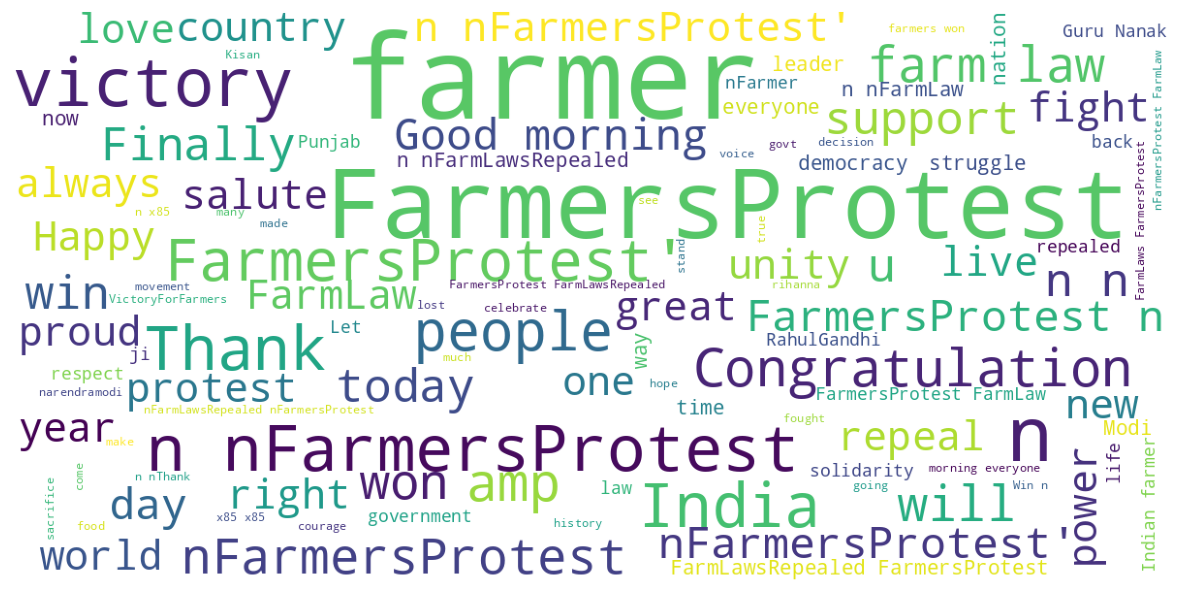

Wordcloud (Negative):


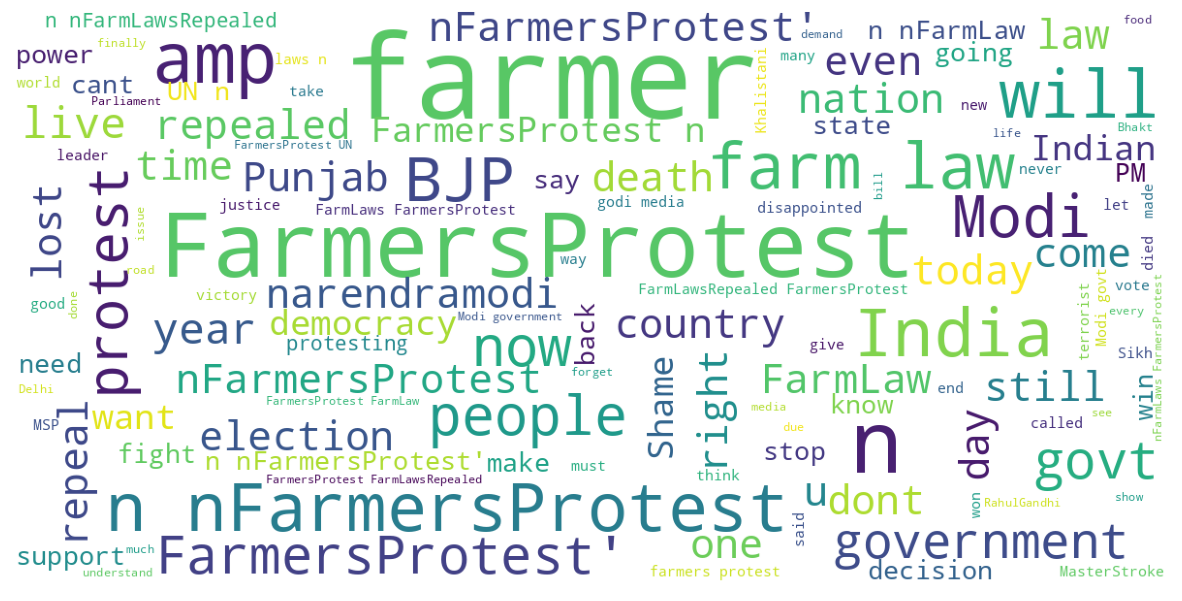

Wordcloud (Neutral):


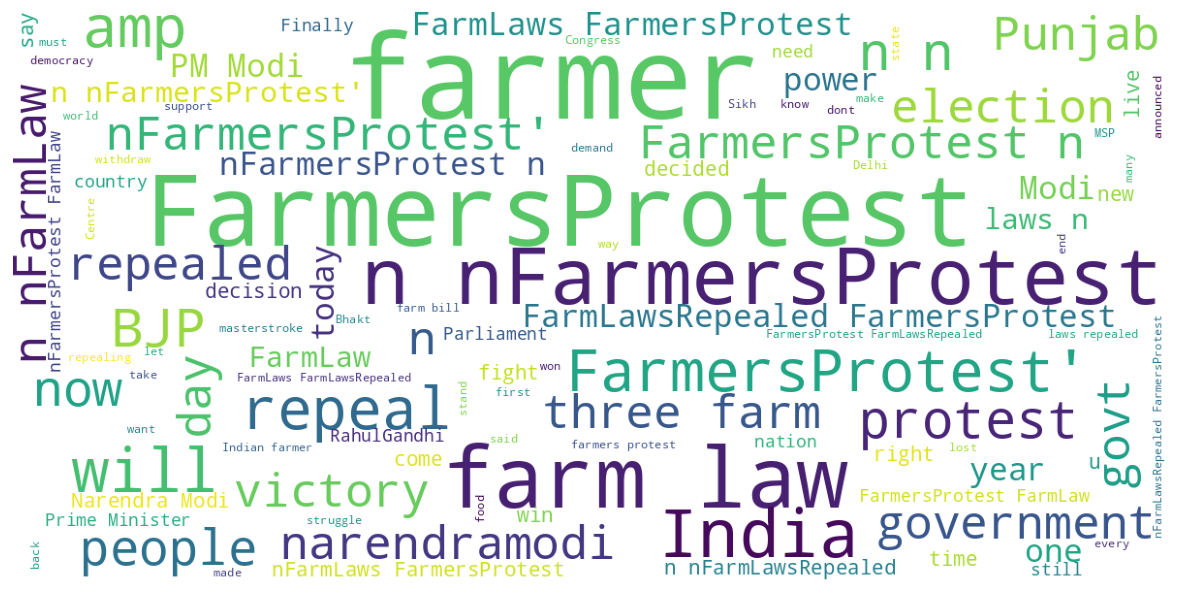

In [ ]:
start_date = "2021-11-05 00:00:00+00:00"
end_date = "2021-11-21 00:00:00+00:00"
seg_dataset2 = segment_by_date(start_date, end_date, farmers, 'date')
length, positives, neutrals, negatives, keyword_to_percent = analyze(seg_dataset2, start_date, end_date, 'renderedContent')



```
Public Sentiment between 2021-11-05 00:00:00+00:00 and 2021-11-21 00:00:00+00:00:

Positive Tweets: 5098
Neutral Tweets: 11037
Negative Tweets: 8433

Total Tweets: 24568

Keywords:
1. ('farmersprotest', 9343)
2. ('farmers', 1907)
3. ('farmlaws', 1760)
4. ('farmlawsrepealed', 1751)
5. ('farm laws', 1518)
6. ('farmlaws farmersprotest', 1123)
7. ('farmlawsrepealed farmersprotest', 1051)
8. ('farmersprotest farmlaws', 899)
9. ('farmersprotest farmlawsrepealed', 882)
10. ('bjp', 605)

Positive Keywords:
1. ('farmersprotest', 2623)
2. ('farmers', 456)
3. ('farmlawsrepealed', 317)
4. ('farmlaws', 291)
5. ('farmers farmersprotest', 213)
6. ('farmlawsrepealed farmersprotest', 195)
7. ('farmlaws farmersprotest', 191)
8. ('farmersprotest farmlawsrepealed', 186)
9. ('farmersprotest farmlaws', 172)
10. ('victory farmers', 140)

Neutral Keywords:
1. ('farmersprotest', 4551)
2. ('farmlaws', 976)
3. ('farmlawsrepealed', 927)
4. ('farm laws', 907)
5. ('farmers', 661)
6. ('farmlaws farmersprotest', 650)
7. ('farmlawsrepealed farmersprotest', 546)
8. ('farmersprotest farmlaws', 480)
9. ('farmersprotest farmlawsrepealed', 410)
10. ('repeal farm', 301)

Negative Keywords:
1. ('farmersprotest', 2169)
2. ('farmers', 790)
3. ('farm laws', 510)
4. ('farmlawsrepealed', 507)
5. ('farmlaws', 493)
6. ('bjp', 369)
7. ('farmlawsrepealed farmersprotest', 310)
8. ('farmersprotest farmlawsrepealed', 286)
9. ('farmlaws farmersprotest', 282)
10. ('farmersprotest farmlaws', 247)
```



Public Sentiment between 2021-01-26 00:00:00+00:00 and 2021-02-01 00:00:00+00:00: 

Positive Tweets: 3423
Neutral Tweets: 16379
Negative Tweets: 18936

Total Tweets: 38738

Keywords:

1. ('farmersprotest', 12696)
2. ('farmers', 1705)
3. ('protest', 1331)
4. ('farmers protest', 1001)
5. ('delhi police', 776)
6. ('farmersprostests farmersprotest', 661)
7. ('sikhs', 559)
8. ('farmers farmersprotest', 542)
9. ('flag', 525)
10. ('bjp', 499)
Positive Keywords: 
1. ('farmersprotest', 1430)
2. ('republic day', 187)
3. ('farmers', 163)
4. ('support farmers', 122)
5. ('peacefulprotestcontinues farmersprotest', 111)
6. ('farmers farmersprotest', 85)
7. ('farmersstandingfirm', 84)
8. ('support farmersprotest', 82)
9. ('republic', 80)
10. ('peace wins', 73)
Neutral Keywords: 
1. ('farmersprotest', 6634)
2. ('farmers', 600)
3. ('farmers protest', 561)
4. ('protest', 554)
5. ('tractor rally', 344)
6. ('rakeshtikait farmersprotest', 318)
7. ('farmerprotest', 304)
8. ('farmersprotest farmerprotest', 30

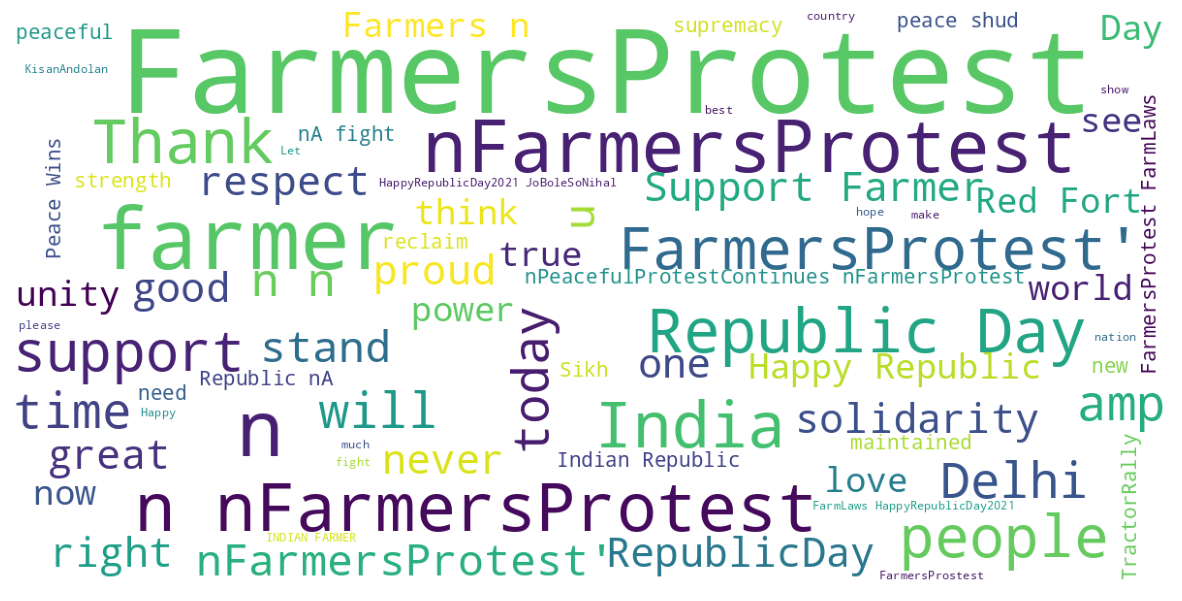

Wordcloud (Negative):


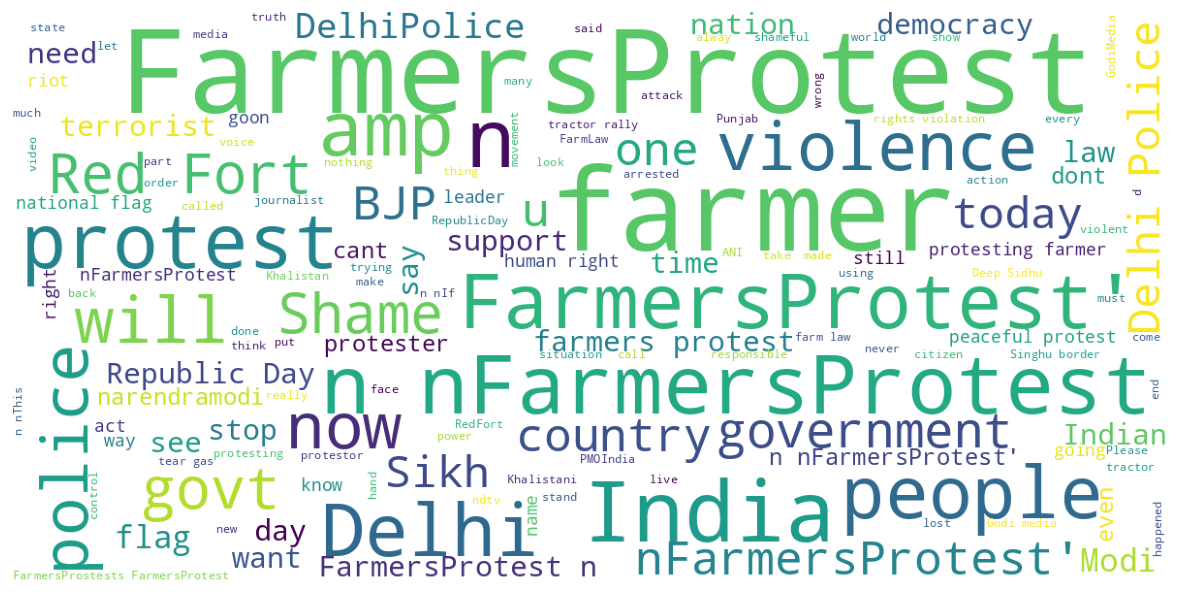

Wordcloud (Neutral):


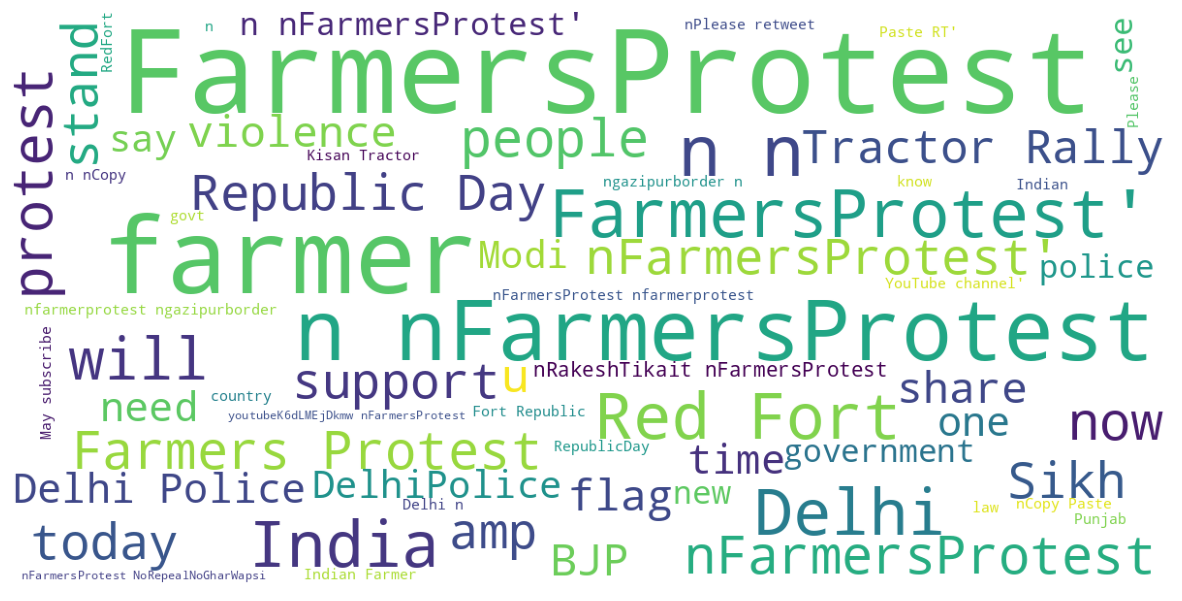

In [ ]:
start_date = "2021-01-26 00:00:00+00:00"
end_date = "2021-02-01 00:00:00+00:00"
seg_dataset3 = segment_by_date(start_date, end_date, farmers, 'date')
length, positives, neutrals, negatives, keyword_to_percent = analyze(seg_dataset3, start_date, end_date, 'renderedContent')



```
Public Sentiment between 2021-01-26 00:00:00+00:00 and 2021-02-01 00:00:00+00:00:

Positive Tweets: 3423
Neutral Tweets: 16379
Negative Tweets: 18936

Total Tweets: 38738

Keywords:
1. ('farmersprotest', 12696)
2. ('farmers', 1705)
3. ('protest', 1331)
4. ('farmers protest', 1001)
5. ('delhi police', 776)
6. ('farmersprostests farmersprotest', 661)
7. ('sikhs', 559)
8. ('farmers farmersprotest', 542)
9. ('flag', 525)
10. ('bjp', 499)

Positive Keywords:
1. ('farmersprotest', 1430)
2. ('republic day', 187)
3. ('farmers', 163)
4. ('support farmers', 122)
5. ('peacefulprotestcontinues farmersprotest', 111)
6. ('farmers farmersprotest', 85)
7. ('farmersstandingfirm', 84)
8. ('support farmersprotest', 82)
9. ('republic', 80)
10. ('peace wins', 73)

Neutral Keywords:
1. ('farmersprotest', 6634)
2. ('farmers', 600)
3. ('farmers protest', 561)
4. ('protest', 554)
5. ('tractor rally', 344)
6. ('rakeshtikait farmersprotest', 318)
7. ('farmerprotest', 304)
8. ('farmersprotest farmerprotest', 302)
9. ('delhi police', 288)
10. ('farmerprotest gazipurborder', 277)

Negative Keywords:
1. ('farmersprotest', 4632)
2. ('farmers', 942)
3. ('protest', 749)
4. ('delhi police', 470)
5. ('farmers protest', 412)
6. ('farmersprostests farmersprotest', 375)
7. ('bjp', 355)
8. ('sikhs', 340)
9. ('flag', 331)
10. ('protesting farmers', 323)

```



And we have now finished conducting our analysis!